# Data Visualization - Notebook 2
## Exploring Dataset Characteristics

- Image size distribution
- Class label distribution
- Sample images from each class


In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from tqdm import tqdm
import random

In [24]:
# Seting matplotlib style
plt.style.use('ggplot')

# Paths
projectRoot = Path().resolve().parent
datasetPath = projectRoot / "CV2024_CW_Dataset"

trainImagePath = datasetPath / "train" / "images"
trainLabelPath = datasetPath / "train" / "labels"
testImagePath = datasetPath / "test" / "images"
testLabelPath = datasetPath / "test" / "labels"

trainImages = sorted(os.listdir(trainImagePath))
testImages = sorted(os.listdir(testImagePath))

print("Dataset paths set up correctly.")

Dataset paths set up correctly.


## Image Size Distribution/Analysis


Extracting image sizes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 458/458 [00:00<00:00, 9263.01it/s]


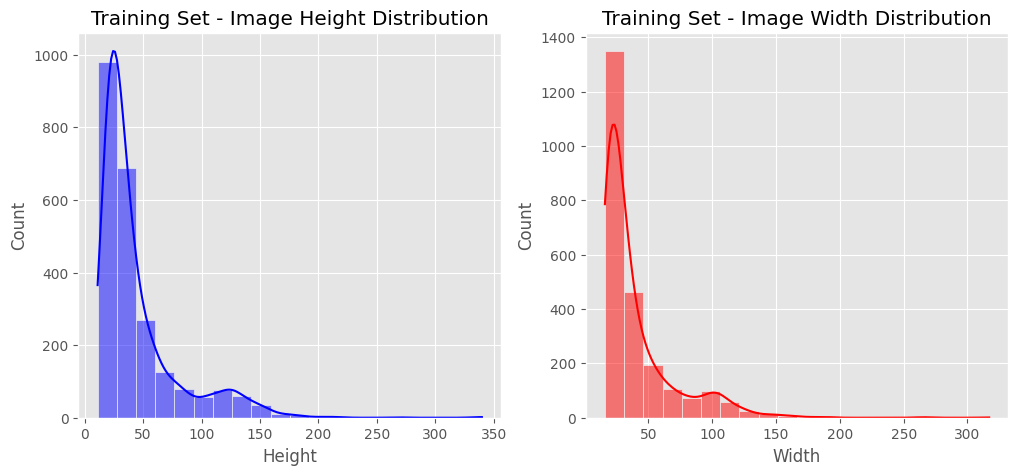

In [3]:
def getImageSizes(imageFolder, imageList):
    sizes = []
    
    for imageName in tqdm(imageList, desc="Extracting image sizes"):
        imagePath = os.path.join(imageFolder, imageName)
        image = cv2.imread(imagePath)
        
        if image is not None:
            sizes.append(image.shape[:2])  # (height, width)
    
    return sizes

# Get sizes for train/test images
trainSizes = getImageSizes(trainImagePath, trainImages)
testSizes = getImageSizes(testImagePath, testImages)

# Convert to DataFrame for plotting
trainSizeDF = pd.DataFrame(trainSizes, columns=["Height", "Width"])
testSizeDF = pd.DataFrame(testSizes, columns=["Height", "Width"])

# Plot image size distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(trainSizeDF["Height"], bins=20, kde=True, ax=axes[0], color="blue")
sns.histplot(trainSizeDF["Width"], bins=20, kde=True, ax=axes[1], color="red")

axes[0].set_title("Training Set - Image Height Distribution")
axes[1].set_title("Training Set - Image Width Distribution")

plt.show()


## Observations on image sizes

- There is significant variation in image size
- Some images are very small while others are much larger
- confirtming we need consistent resizing with padding to avoid distortions

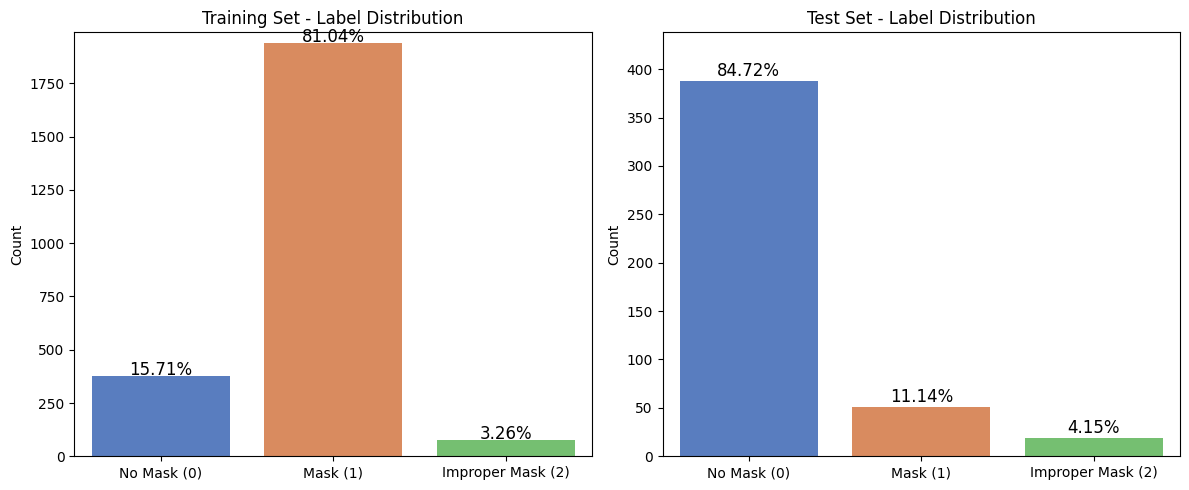

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# label counts from notebook 1
trainLabelCounts = {0: 376, 1: 1940, 2: 78}
testLabelCounts = {0: 388, 1: 51, 2: 19}

#class lavbels
labels = ["No Mask (0)", "Mask (1)", "Improper Mask (2)"]

# training values
trainValues = [trainLabelCounts[0], trainLabelCounts[1], trainLabelCounts[2]]
trainPercentages = [v / sum(trainValues) * 100 for v in trainValues]

# Test values
testValues = [testLabelCounts[0], testLabelCounts[1], testLabelCounts[2]]
testPercentages = [v / sum(testValues) * 100 for v in testValues]

# side by side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training set plot
sns.barplot(x=labels, y=trainValues, ax=axes[0], hue=labels, dodge=False, legend=False, palette="muted")
for i, v in enumerate(trainValues):
    axes[0].text(i, v + 5, f"{trainPercentages[i]:.2f}%", ha='center', fontsize=12)
axes[0].set_title("Training Set - Label Distribution")
axes[0].set_ylabel("Count")
axes[0].set_ylim(0, max(trainValues) + 50)

# Test set plot
sns.barplot(x=labels, y=testValues, ax=axes[1], hue=labels, dodge=False, legend=False, palette="muted")
for i, v in enumerate(testValues):
    axes[1].text(i, v + 5, f"{testPercentages[i]:.2f}%", ha='center', fontsize=12)
axes[1].set_title("Test Set - Label Distribution")
axes[1].set_ylabel("Count")
axes[1].set_ylim(0, max(testValues) + 50)

plt.tight_layout()
plt.show()


## Label Distribution Analysis

### Key Observations:
- **Training set is highly imbalanced**
- **Test set distribution is inconsistent with training data**
- The **underrepresentation of Improper Mask (2) in both sets** could negatively impact model performance for this class

### Implications for Model Training:
- **Model may become biased** toward dominant class
- **Generalization may suffer** because of the mismatch between training and test distribution
- **Data balancing techniques** will look into augmentation/resampling



## Displaying Sample Images


In [20]:
import os
import cv2
import random
import matplotlib.pyplot as plt

def selectAndDisplayImages(imageFolder, labelFolder, numSamples=3):

    labels = {0: "No Mask", 1: "Mask", 2: "Improper Mask"}
    classSamples = {0: [], 1: [], 2: []}

    # randomly select imgs
    for labelFile in os.listdir(labelFolder):
        labelPath = os.path.join(labelFolder, labelFile)
        imageFile = labelFile.replace(".txt", ".jpeg")
        imagePath = os.path.join(imageFolder, imageFile)

        with open(labelPath, "r") as file:
            label = int(file.read().strip())

        if label in classSamples and len(classSamples[label]) < numSamples:
            classSamples[label].append(imagePath)

    # set up figure to display imgs
    fig, axes = plt.subplots(numSamples, 3, figsize=(9, numSamples * 3))

    for i in range(numSamples):
        for label in [0, 1, 2]:
            img = cv2.imread(classSamples[label][i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for correct display

            axes[i, label].imshow(img)
            axes[i, label].axis("off")
            if i == 0:
                axes[i, label].set_title(labels[label])  # Set class title only for the top row

    plt.tight_layout()
    plt.show()


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


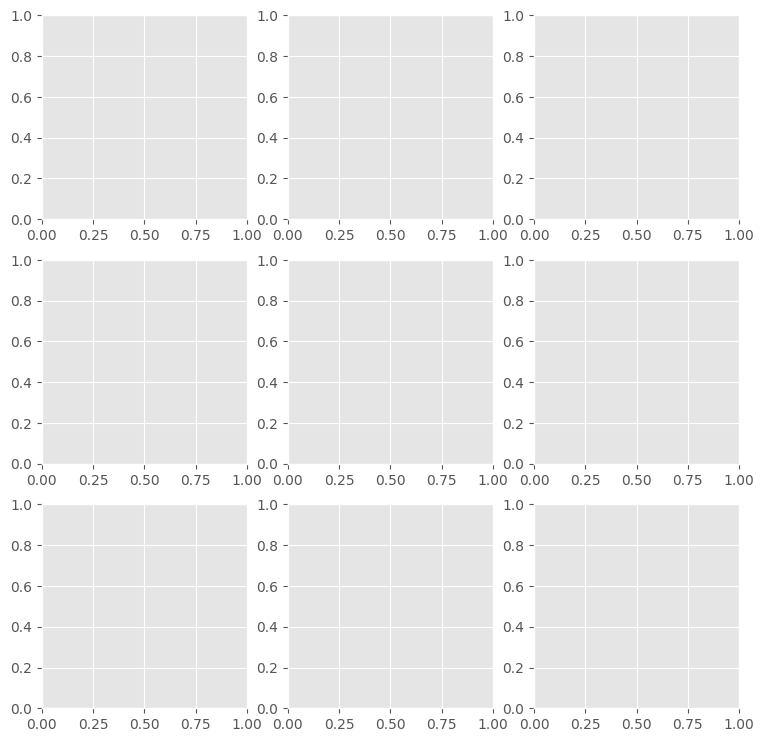

In [23]:
selectAndDisplayImages("MaskDetection/TestingImages", trainLabelPath)


## Sample Images from Each Class

### Overview
Grid displays randomly selected imgs from all classes:
- **No Mask (0)**: No face mask at all
- **Mask (1)**: correctly worn face masks covering mouth/nose
- **Improper Mask (2)**: Improperly worn face masks eg pull down mask not covering nose

### Observations
- images differ alot in **size, resolution, and lighting conditions**.
- Some images are **pixelated/blurry**, which will severly affect model performence
- **clear visual distinctions** exist between classes, but some **wrong mask cases may be very hard to detect**

### Solution
- **Make image sizes equal** by utilising padding
- **Enhance image quality** with preprocessing techniquees
- **Address class imbalance** prior to model development

